# Pseudo Riemannian VAE Geodesics

In [1]:
#Modules
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap, jit, grad

import torch

import haiku as hk

import torchvision.utils as vutils

import os

#numpy
import numpy as np

from abc import ABC

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from geometry.pseudo_riemannian.geodesics import AdaGEORCE, JAXOptimization, ScipyOptimization

from load_pseudo_manifold import load_manifold
from vae.model_loader import mnist_generator, svhn_generator, celeba_generator, load_model

from vae.models import mnist_encoder
from vae.models import mnist_decoder
from vae.models import mnist_vae

from vae.models import svhn_encoder
from vae.models import svhn_decoder
from vae.models import svhn_vae

from vae.models import celeba_encoder
from vae.models import celeba_decoder
from vae.models import celeba_vae

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-11-09 05:14:00.217555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
T = 100
max_iter = 100
intrinsic_batch = None
extrinsic_batch = None
tol = 1e-2
plot_grid = T//10

In [3]:
plt.rcParams.update({'font.size': 12})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [4]:
seed = 2712
model_path = 'models/'
figure_path = '../figures/vae/'

In [5]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Functions

In [6]:
def init_fun(z0,zT,T):
    return z0+(zT-z0)*jnp.linspace(0.0,
                                   1.0,
                                   T,
                                   endpoint=False,
                                   dtype=z0.dtype)[1:].reshape(-1,1)

In [7]:
def geodesic_evaluation(M, z0, zT, Geodesic):
    zt, grad, idx = Geodesic(z0,zT)
    length = M.length(zt)
    xt = vmap(M.f)(zt)
    
    return {'zt': zt, 'xt': xt, 'grad': grad, 'idx': idx, 'length': length}
    

## VAE MNIST

In [8]:
latent_dim = 8

In [9]:
z0, zT, M = load_manifold("mnist", dim=latent_dim)

2024-11-09 04:48:53.763228: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-11-09 04:48:53.875649: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Loading Data

In [10]:
mnist_dataloader = mnist_generator(seed=2712,
                                   batch_size=64,
                                   split='train[:80%]')

### Loading Model

In [11]:
@hk.transform
def mnist_tvae(x):


    vae = mnist_vae(
                encoder=mnist_encoder(latent_dim=latent_dim),
                decoder=mnist_decoder(),
    )

    return vae(x)

@hk.transform
def mnist_tencoder(x):


    encoder = mnist_encoder(latent_dim=latent_dim)

    return encoder(x)[0]

@hk.transform
def mnist_tdecoder(x):

    decoder = mnist_decoder()

    return decoder(x)

In [12]:
mnist_state = load_model(''.join((model_path, f'mnist_{latent_dim}/')))

In [13]:
mnist_encoder_fun = lambda x: mnist_tencoder.apply(mnist_state.params, None, x.reshape(-1,
                                                                                       28,
                                                                                       28,
                                                                                       1)).reshape(-1,
                                                                                                   latent_dim).squeeze()
mnist_decoder_fun = lambda x: mnist_tdecoder.apply(mnist_state.params, None, x.reshape(-1,
                                                                                       latent_dim)).reshape(-1,
                                                                                                            28*28).squeeze()
mnist_vae_fun = lambda x: mnist_tvae.apply(mnist_state.params, mnist_state.rng_key, x)

In [14]:
mnist_data = next(mnist_dataloader).x

### Plotting Reconstruction

In [15]:
mnist_data = next(mnist_dataloader).x

In [16]:
mnist_rec = mnist_vae_fun(mnist_data)

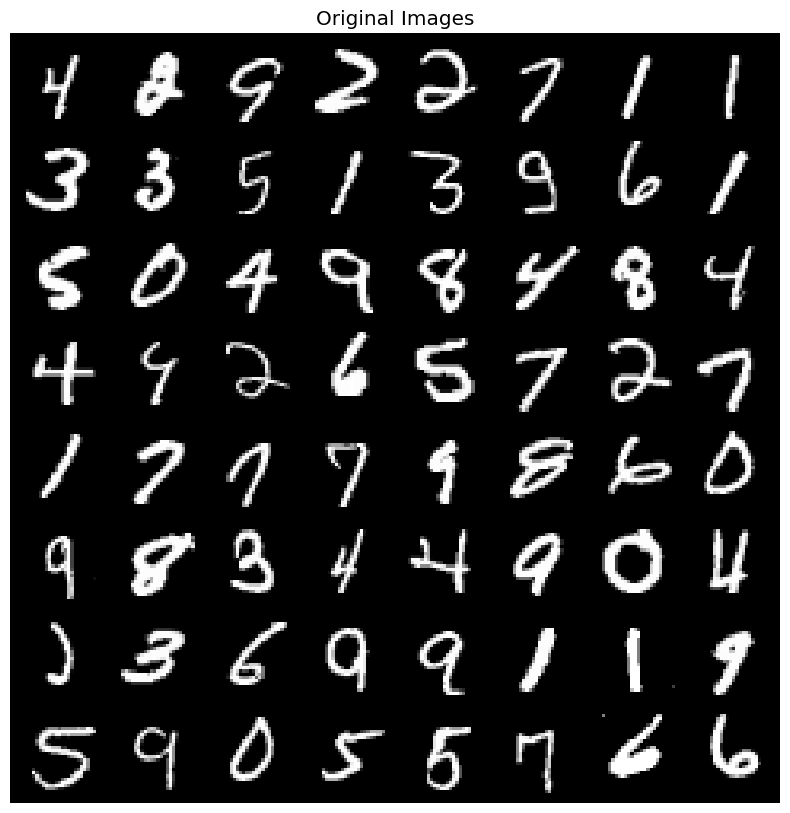

In [17]:
plot_val = torch.from_numpy(np.transpose(np.array(mnist_data), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

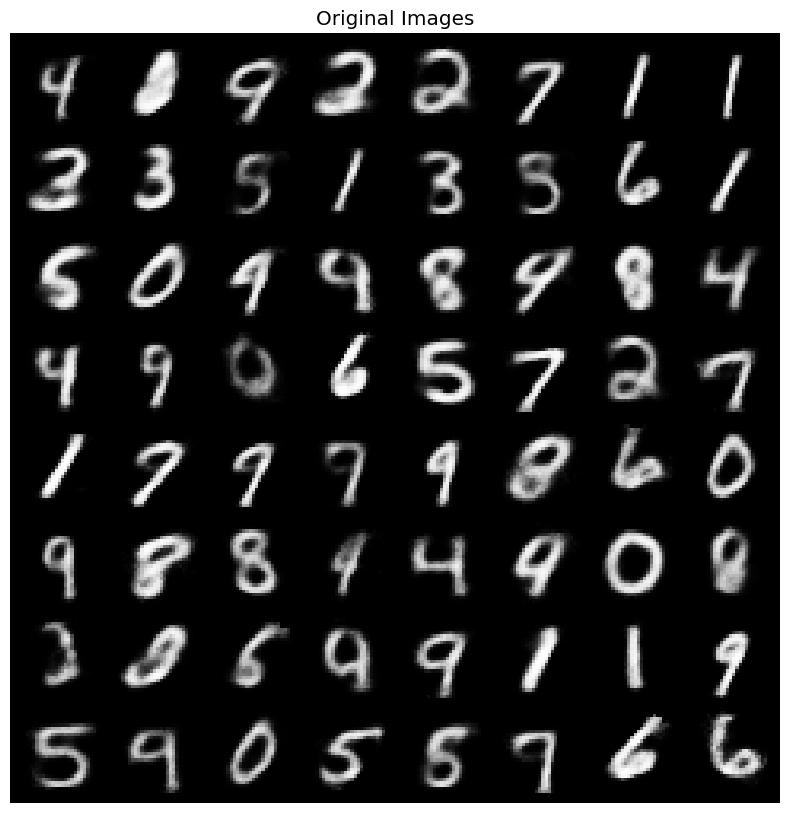

In [18]:
plot_val = torch.from_numpy(np.transpose(np.array(mnist_rec.mu_xz), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

### Computing Geodesics

In [19]:
mnist_methods = {}

#### Intilization

In [20]:
zt_init = jnp.vstack((z0, init_fun(z0, zT, T), zT))
xt_init = vmap(M.f)(zt_init)
length = M.length(zt_init)
idx = 0
mnist_methods['Initilization']={'zt': zt_init, 'xt': xt_init, 'grad': None, 'idx': idx, 'length': length}

#### BFGS

In [21]:
Geodesic = ScipyOptimization(M, 
                             init_fun=init_fun,
                             T=T,
                             max_iter=max_iter, 
                             tol=tol, 
                             method="BFGS",
                            )
mnist_methods['BFGS'] = geodesic_evaluation(M, z0, zT, Geodesic)

/home/fmry/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/home/fmry/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:571: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '


#### ADAM

In [30]:
Geodesic = JAXOptimization(M, 
                           init_fun=init_fun,
                           T=T,
                           lr_rate=0.01,
                           intrinsic_batch_size=100, 
                           extrinsic_batch_size=extrinsic_batch, 
                           max_iter=1000, 
                           tol=1e-3)
mnist_methods['ADAM'] = geodesic_evaluation(M, z0, zT, jit(Geodesic))

#### AdaGEORCE

In [ ]:
Geodesic = AdaGEORCE(M, 
                     init_fun=init_fun,
                     T=T, 
                     alpha=1e-1,
                     lr_rate=0.1, 
                     intrinsic_batch_size=100,
                     extrinsic_batch_size=8, 
                     beta1=0.5, 
                     beta2=0.5, 
                     max_iter=1, 
                     tol=tol)
mnist_methods['AdaGEORCE'] = geodesic_evaluation(M, z0, zT, jit(Geodesic))

### Plotting

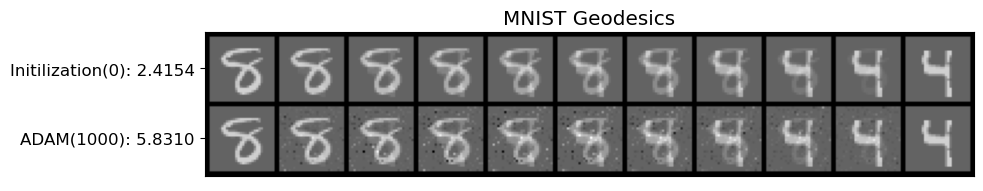

In [31]:
img_height = 28+2
tick_list = [img_height/2+j*img_height for j in range(len(mnist_methods))]
xt = jnp.stack([value['zt'][::plot_grid] for key, value in mnist_methods.items()]).reshape(-1,28,28,1)
length = [f"{key}({value['idx']}): {value['length']:.4f}" for key, value in mnist_methods.items()]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"MNIST Geodesics")
plot_val = torch.from_numpy(np.transpose(np.array(xt), (0,3,1,2)))
ax.imshow(vutils.make_grid(plot_val, padding=2, normalize=True, nrow=plot_grid+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)
ax.set_yticks(tick_list)
ax.set_yticklabels(length)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}mnist_{latent_dim}.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')


## VAE SVHN

In [ ]:
latent_dim = 32

In [ ]:
z0, zT, M = load_manifold("svhn", dim=latent_dim)

### Loading Data

In [ ]:
svhn_dataloader = svhn_generator(data_dir="../../../Data/SVHN/",
                                 batch_size=64,
                                 seed=2712,
                                 split='train[:80%]')

### Loading Model

In [ ]:
@hk.transform
def svhn_tvae(x):


    vae = svhn_vae(
                encoder=svhn_encoder(latent_dim=latent_dim),
                decoder=svhn_decoder(),
    )

    return vae(x)

@hk.transform_with_state
def svhn_tencoder(x):


    encoder = svhn_encoder(latent_dim=latent_dim)

    return encoder(x)

@hk.transform_with_state
def svhn_tdecoder(x):

    decoder = svhn_decoder(latent_dim=latent_dim)

    return decoder(x)

In [ ]:
svhn_state = load_model(''.join((model_path, f'svhn_{latent_dim}/')))

In [ ]:
svhn_encoder_fun = lambda x: svhn_tencoder.apply(svhn_state.params, svhn_state.rng_key, x)
svhn_decoder_fun = lambda x: svhn_tdecoder.apply(svhn_state.params, svhn_state.rng_key, x)
svhn_vae_fun = lambda x: svhn_tvae.apply(svhn_state.params, svhn_state.rng_key, x)

### Plotting Reconstruction

In [ ]:
svhn_data = next(svhn_dataloader).x

In [ ]:
svhn_rec = svhn_vae_fun(svhn_data)

In [ ]:
plot_val = torch.from_numpy(np.transpose(np.array(svhn_data), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
plot_val = torch.from_numpy(np.transpose(np.array(svhn_rec.mu_xz), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

### Computing Geodesics

In [ ]:
svhn_methods = {}

#### Intilization

In [ ]:
zt_init = jnp.vstack((z0, init_fun(z0, zT, T), zT))
xt_init = vmap(M.f)(zt_init)
length = M.length(zt_init)
idx = 0
svhn_methods['Initilization']={'zt': zt_init, 'xt': xt_init, 'grad': None, 'idx': idx, 'length': length}

#### GEORCE

In [ ]:
Geodesic = GEORCE(M,
                  init_fun=init_fun,
                  T=T,
                  max_iter=max_iter,
                  tol=tol,
                  line_search_method="soft",
                  line_search_params = {'rho':0.5},
                 )
svhn_methods['GEORCE'] = geodesic_evaluation(M, z0, zT, jit(Geodesic))

#### BFGS

In [ ]:
Geodesic = ScipyOptimization(M, 
                             init_fun=init_fun,
                             T=T,
                             max_iter=max_iter, 
                             tol=tol, 
                             method="BFGS",
                            )
svhn_methods['BFGS'] = geodesic_evaluation(M, z0, zT, Geodesic)

#### ADAM

In [ ]:
Geodesic = JAXOptimization(M, 
                           init_fun=init_fun,
                           T=T,
                           lr_rate=0.01,
                           intrinsic_batch_size=intrinsic_batch,
                           extrinsic_batch_size=extrinsic_batch,
                           max_iter=max_iter, 
                           tol=tol)
svhn_methods['ADAM'] = geodesic_evaluation(M, z0, zT, jit(Geodesic))

#### AdaGEORCE

In [ ]:
Geodesic = AdaGEORCE(M, 
                     init_fun=init_fun,
                     T=T, 
                     alpha=1e-3,
                     lr_rate=0.1, 
                     intrinsic_batch_size=intrinsic_batch,
                     extrinsic_batch_size=extrinsic_batch, 
                     beta1=0.5, 
                     beta2=0.5, 
                     max_iter=max_iter, 
                     tol=tol)
svhn_methods['AdaGEORCE'] = geodesic_evaluation(M, z0, zT, jit(Geodesic))

### Plotting

In [ ]:
img_height = 32+2
tick_list = [img_height/2+j*img_height for j in range(len(svhn_methods))]
xt = jnp.stack([value['xt'][::plot_grid] for key, value in svhn_methods.items()]).reshape(-1,32,32,3)
length = [f"{key}({value['idx']}): {value['length']:.4f}" for key, value in svhn_methods.items()]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"SVHN geodesics")
plot_val = torch.from_numpy(np.transpose(np.array(xt), (0,3,1,2)))
ax.imshow(vutils.make_grid(plot_val, padding=2, normalize=True, nrow=plot_grid+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)
ax.set_yticks(tick_list)
ax.set_yticklabels(length)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}svhn_{latent_dim}.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

## VAE CelebA

In [ ]:
latent_dim = 32

In [ ]:
z0, zT, M = load_manifold("celeba", dim=latent_dim)

### Loading Data

In [ ]:
celeba_dataloader = celeba_generator(data_dir="../../../Data/CelebA/",
                                     batch_size=64,
                                     seed=2712, 
                                     split=0.8)

### Loading Model

In [ ]:
@hk.transform
def celeba_tvae(x):


    vae = celeba_vae(
                encoder=celeba_encoder(latent_dim=latent_dim),
                decoder=celeba_decoder(),
    )

    return vae(x)

@hk.transform
def celeba_tencoder(x):


    encoder = celeba_encoder(latent_dim=latent_dim)

    return encoder(x)

@hk.transform
def celeba_tdecoder(x):

    decoder = celeba_decoder(latent_dim=latent_dim)

    return decoder(x)

In [ ]:
celeba_state = load_model(''.join((model_path, f'celeba_{latent_dim}/')))

In [ ]:
celeba_encoder_fun = lambda x: celeba_tencoder.apply(celeba_state.params, celeba_state.rng_key, x)
celeba_decoder_fun = lambda x: celeba_tdecoder.apply(celeba_state.params, celeba_state.rng_key, x)
celeba_vae_fun = lambda x: celeba_tvae.apply(celeba_state.params, celeba_state.rng_key, x)

### Plotting Reconstruction

In [ ]:
celeba_data = next(celeba_dataloader).x

In [ ]:
celeba_rec = celeba_vae_fun(celeba_data)

In [ ]:
plot_val = torch.from_numpy(np.transpose(np.array(celeba_data), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
plot_val = torch.from_numpy(np.transpose(np.array(celeba_rec.mu_xz), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

### Computing Geodesics

In [ ]:
celeba_methods = {}

#### Intilization

In [ ]:
zt_init = jnp.vstack((z0, init_fun(z0, zT, T), zT))
xt_init = vmap(M.f)(zt_init)
length = M.length(zt_init)
idx = 0
celeba_methods['Initilization']={'zt': zt_init, 'xt': xt_init, 'grad': None, 'idx': idx, 'length': length}

#### GEORCE

In [ ]:
Geodesic = GEORCE(M,
                  init_fun=init_fun,
                  T=T,
                  max_iter=max_iter,
                  tol=tol,
                  line_search_method="soft",
                  line_search_params = {'rho':0.5},
                 )
celeba_methods['GEORCE'] = geodesic_evaluation(M, z0, zT, jit(Geodesic))

#### BFGS

In [ ]:
Geodesic = ScipyOptimization(M, 
                             init_fun=init_fun,
                             T=T,
                             max_iter=max_iter, 
                             tol=tol, 
                             method="BFGS",
                            )
celeba_methods['BFGS'] = geodesic_evaluation(M, z0, zT, Geodesic)

#### ADAM

In [ ]:
Geodesic = JAXOptimization(M, 
                           init_fun=init_fun,
                           T=T,
                           lr_rate=0.01,
                           intrinsic_batch_size=intrinsic_batch,
                           extrinsic_batch_size=extrinsic_batch, 
                           max_iter=max_iter, 
                           tol=tol)
celeba_methods['ADAM'] = geodesic_evaluation(M, z0, zT, jit(Geodesic))

#### AdaGEORCE

In [ ]:
Geodesic = AdaGEORCE(M, 
                     init_fun=init_fun,
                     T=T, 
                     alpha=1e-3,
                     lr_rate=0.1, 
                     intrinsic_batch_size=intrinsic_batch,
                     extrinsic_batch_size=extrinsic_batch, 
                     beta1=0.5, 
                     beta2=0.5, 
                     max_iter=max_iter, 
                     tol=tol)
celeba_methods['AdaGEORCE'] = geodesic_evaluation(M, z0, zT, jit(Geodesic))

### Plotting

In [ ]:
img_height = 64+2
tick_list = [img_height/2+j*img_height for j in range(len(celeba_methods))]
xt = jnp.stack([value['xt'][::plot_grid] for key, value in celeba_methods.items()]).reshape(-1,64,64,3)
length = [f"{key}({value['idx']}): {value['length']:.4f}" for key, value in celeba_methods.items()]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title(f"CelebA geodesics")
plot_val = torch.from_numpy(np.transpose(np.array(xt), (0,3,1,2)))
ax.imshow(vutils.make_grid(plot_val, padding=2, normalize=True, nrow=plot_grid+1).permute(1, 2, 0))
ax.axes.get_xaxis().set_visible(False)
ax.set_yticks(tick_list)
ax.set_yticklabels(length)

fig.tight_layout()

plt.show()

save_path = f'{figure_path}celeba_{latent_dim}.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')